In [ ]:
!unzip /content/drive/MyDrive/dataset2_audio_animal.zip -d /content/drive/MyDrive/dataset2_audio_animal

In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_clean_spectrogram(file_path, save_path):
    # Load the audio file
    y, sr = librosa.load(file_path)
    # Create a spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plotting the spectrogram without any additional elements
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')  # Don't show axes.
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free memory

# Path to your dataset
path_to_audio_files = '/content/drive/MyDrive/dataset2_audio_animal/dataset2_audio_animal'

# Path to save spectrograms
path_to_save_spectrograms = '/content/drive/MyDrive/clean_spectrograms2/'

# Ensure the save directory exists, if not, create it
os.makedirs(path_to_save_spectrograms, exist_ok=True)

# New list of animal classes
animal_classes = [
    'bat', 'elephant', 'hornbill', 'junglefowl', 'macaque',
    'myna', 'peafowl', 'pig', 'squirrel', 'toad'
]

# Process each file in the dataset
for subfolder in animal_classes:
    full_path = os.path.join(path_to_audio_files, subfolder)
    save_folder = os.path.join(path_to_save_spectrograms, subfolder)
    os.makedirs(save_folder, exist_ok=True)  # Create a subfolder for images

    # Process each file in the directory
    for file in os.listdir(full_path):
        if file.endswith('.wav'):  # Check if the file is a WAV file
            file_path = os.path.join(full_path, file)
            save_path = os.path.join(save_folder, f"{os.path.splitext(file)[0]}.png")
            try:
                create_clean_spectrogram(file_path, save_path)
            except Exception as e:
                print(f"Failed to process {file}: {str(e)}")


In [3]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/clean_spectrograms2", transform=data_transform)

# Define data loader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet50 model
model = torchvision.models.resnet50(pretrained=True)
# Modify the model to remove the last fully connected layer
model = torch.nn.Sequential(*list(model.children())[:-1])
# Set model to evaluation mode
model.eval()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Extract features and labels
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        features = model(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.numpy())

# Concatenate features and labels
features = np.concatenate(features_list)
labels = np.concatenate(labels_list)

# Flatten features for each image
features = features.reshape(features.shape[0], -1)

# Create pandas DataFrame
df = pd.DataFrame(features)

# Get folder names to assign labels based on folder index
folder_names = dataset.classes
# Assign numerical labels based on folder names
numerical_labels = {name: i for i, name in enumerate(folder_names)}
# Assign labels to the DataFrame
df['label'] = [numerical_labels[folder_names[label]] for label in labels]

# Save DataFrame to Excel
df.to_excel('animal_dataset_clean_spectrograms2.xlsx', index=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s] 


In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load Iris dataset from Excel file
data_df = pd.read_excel('/content/animal_dataset_clean_spectrograms2.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values


print(X.shape)
print(y.shape)

print(X)
print(y)



(400, 2048)
(400,)
[[3.67388353e-02 0.00000000e+00 1.14563584e-01 ... 1.96997505e-02
  2.11623251e-01 5.38647771e-01]
 [1.12805024e-01 2.71614473e-02 1.32029310e-01 ... 1.17802195e-01
  1.16445214e-01 4.00349081e-01]
 [1.75624147e-01 6.43334351e-03 2.44430974e-01 ... 6.19229376e-02
  9.24384966e-02 3.91372532e-01]
 ...
 [6.30156875e-01 7.08599866e-04 2.99712777e-01 ... 9.14225057e-02
  1.88195825e-01 3.30033213e-01]
 [3.52686673e-01 3.89273744e-04 1.79252326e-01 ... 5.71411103e-02
  2.11755447e-02 2.88071781e-01]
 [3.89696121e-01 6.50826935e-03 1.88426226e-01 ... 8.12981427e-02
  2.00398117e-01 1.53760478e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4

(400, 2048)
(400,)
Epoch [50/1500], Loss: 1.6196
Epoch [100/1500], Loss: 1.4748
Epoch [150/1500], Loss: 1.4662
Epoch [200/1500], Loss: 1.4652
Epoch [250/1500], Loss: 1.4648
Epoch [300/1500], Loss: 1.4647
Epoch [350/1500], Loss: 1.4646
Epoch [400/1500], Loss: 1.4645
Epoch [450/1500], Loss: 1.4645
Epoch [500/1500], Loss: 1.4644
Epoch [550/1500], Loss: 1.4644
Epoch [600/1500], Loss: 1.4644
Epoch [650/1500], Loss: 1.4644
Epoch [700/1500], Loss: 1.4644
Epoch [750/1500], Loss: 1.4643
Epoch [800/1500], Loss: 1.4643
Epoch [850/1500], Loss: 1.4643
Epoch [900/1500], Loss: 1.4643
Epoch [950/1500], Loss: 1.4643
Epoch [1000/1500], Loss: 1.4643
Epoch [1050/1500], Loss: 1.4643
Epoch [1100/1500], Loss: 1.4643
Epoch [1150/1500], Loss: 1.4643
Epoch [1200/1500], Loss: 1.4643
Epoch [1250/1500], Loss: 1.4643
Epoch [1300/1500], Loss: 1.4643
Epoch [1350/1500], Loss: 1.4643
Epoch [1400/1500], Loss: 1.4643
Epoch [1450/1500], Loss: 1.4643
Epoch [1500/1500], Loss: 1.4643


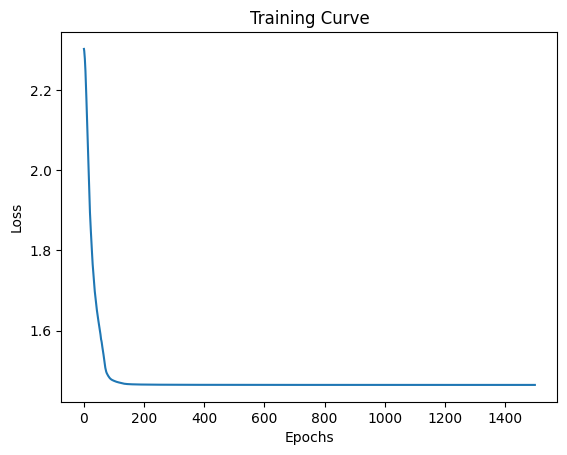

Training Confusion Matrix:
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0]
 [ 0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  0  0 32  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0]
 [ 0  0  0  1  0  0  0 31  0  0]
 [ 0  0  0  0  0  0  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 32]]
Training Accuracy: 0.996875

Testing Confusion Matrix:
[[8 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0]
 [0 0 1 0 0 0 7 0 0 0]
 [0 1 1 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 8]]
Testing Accuracy: 0.9625


In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load dataset from Excel file
data_df = pd.read_excel('/content/animal_dataset_clean_spectrograms2.xlsx')
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values

# Apply Min-Max scaling
print(X.shape)
print(y.shape)

# Apply Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

# Define training function
def train(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    train_losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return train_losses

# Initialize the model, loss function, and optimizer
input_size = 2048
hidden_size1 = 100
hidden_size2 = 50
output_size = 10
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = train(model, criterion, optimizer, X_train, y_train, num_epochs=1500)

# Plot the training curve
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.show()

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix and accuracy for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())
train_accuracy = accuracy_score(y_train.numpy(), train_predicted.numpy())

print("Training Confusion Matrix:")
print(train_cm)
print("Training Accuracy:", train_accuracy)

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix and accuracy for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())
test_accuracy = accuracy_score(y_test.numpy(), test_predicted.numpy())

print("\nTesting Confusion Matrix:")
print(test_cm)
print("Testing Accuracy:", test_accuracy)


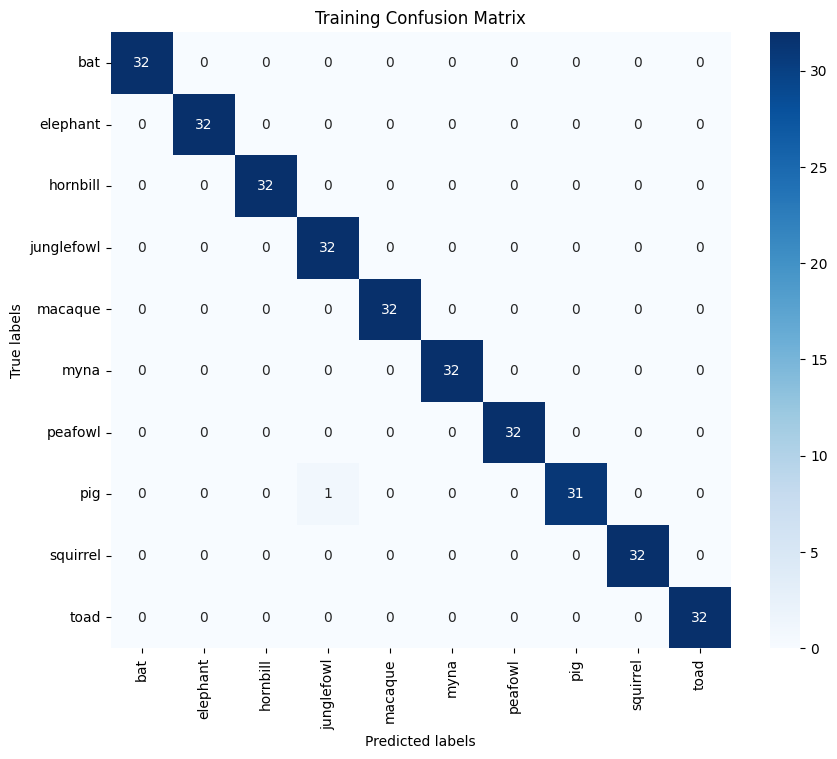

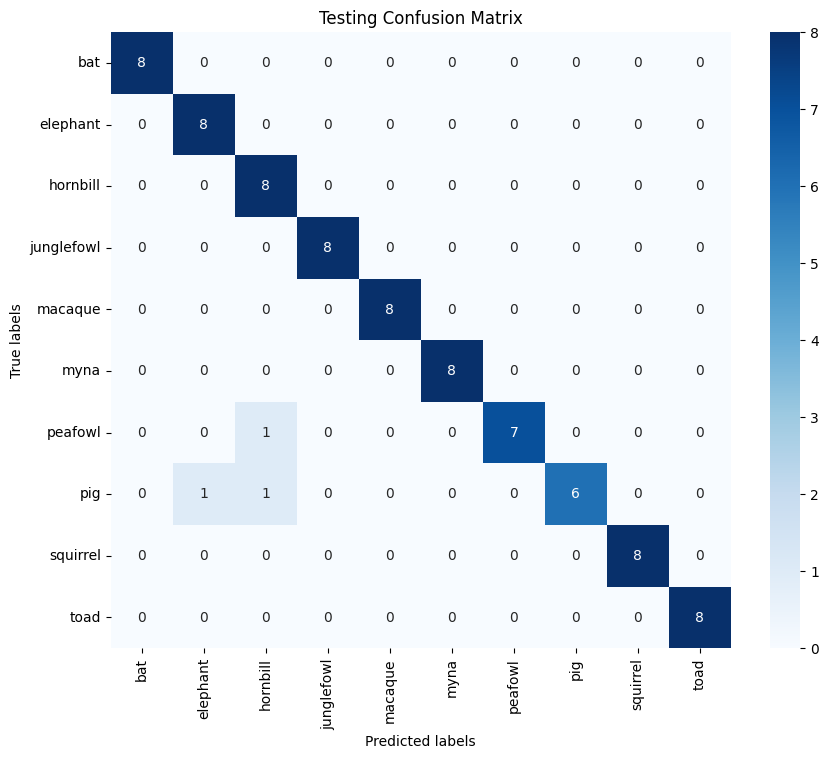

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix

# Assume 'dataset' and 'model' have been defined as in your earlier scripts

# Get class labels from dataset
class_labels = dataset.classes

# Predict classes for training set
with torch.no_grad():
    train_outputs = model(X_train)
    _, train_predicted = torch.max(train_outputs, 1)

# Calculate confusion matrix for training set
train_cm = confusion_matrix(y_train.numpy(), train_predicted.numpy())

# Plot training confusion matrix
plt.figure(figsize=(10, 8))  # Adjusted for potentially more classes
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Training Confusion Matrix')
plt.show()

# Predict classes for test set
with torch.no_grad():
    test_outputs = model(X_test)
    _, test_predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix for test set
test_cm = confusion_matrix(y_test.numpy(), test_predicted.numpy())

# Plot testing confusion matrix
plt.figure(figsize=(10, 8))  # Adjusted for potentially more classes
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Testing Confusion Matrix')
plt.show()

